# Compare word2vec training  iterations (AllPositive dataset)

In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


### Post-processing of data

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

In [4]:
def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_postprocessed = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_postprocessed = [s for s in spectrums_postprocessed if s is not None]

## Load pretrained spec2vec models and calculate scores

In [5]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument 

In [6]:
documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums_postprocessed]

In [7]:
documents[0].words[:10]

['peak@289.29',
 'peak@295.55',
 'peak@298.49',
 'peak@317.32',
 'peak@319.66',
 'peak@324.48',
 'peak@325.32',
 'peak@339.79',
 'peak@343.95',
 'peak@347.02']

### Load reference scores

In [8]:
filename = os.path.join(path_data,'similarities_daylight2048_jaccard.npy')
matrix_similarities_fingerprint_daylight = np.load(filename)

In [9]:
from custom_functions.plotting_functions import plot_precentile

## Actual score calculation
+ Using ``Spec2VecParallel`` with ``intensity_weighting_power=0.5``.
+ Calculate matrix of all-vs-all similarity scores.
+ Iterate over trained models after different numbers of iterations.

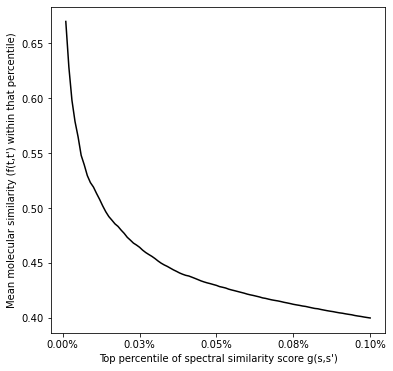

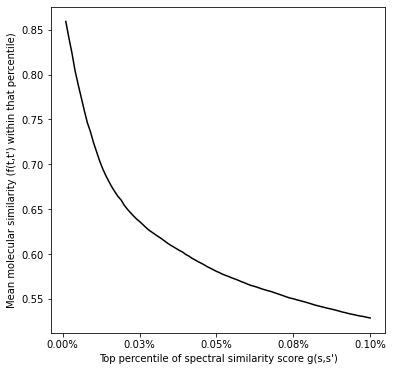

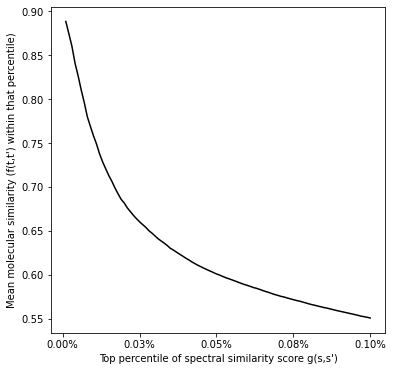

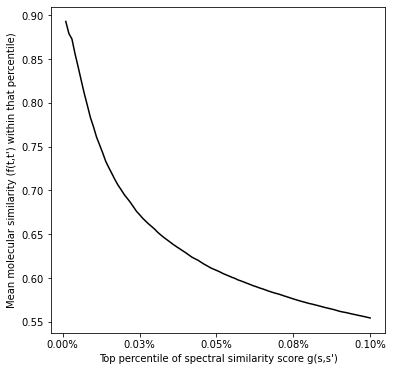

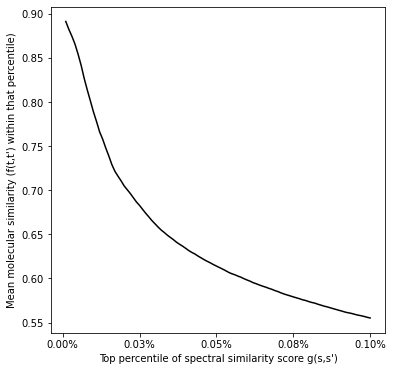

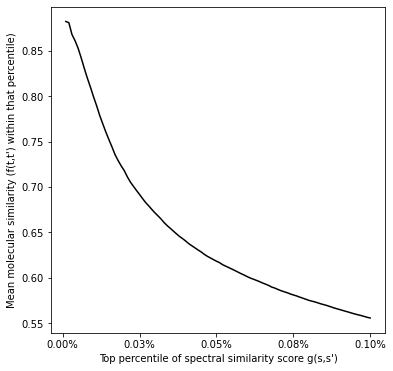

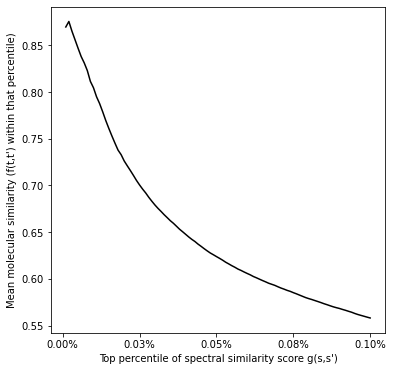

In [11]:
path_models = os.path.join(path_data, "trained_models")

for iteration in [1, 5, 10, 15, 20, 25, 30]:
    filename = "spec2vec_UniqueInchikeys_ratio05_filtered_iter_{}.model".format(iteration)
    model_file = os.path.join(path_models, filename)

    # Load pretrained model
    model = gensim.models.Word2Vec.load(model_file)
    
    # Score calculations
    spec2vec_similarity = Spec2VecParallel(model, intensity_weighting_power=0.5)
    similarity_matrix = spec2vec_similarity(documents, documents)
    
    # Compare to reference scores
    percentile_spec2vec_2dec_AllPos = plot_precentile(matrix_similarities_fingerprint_daylight,
                                                      similarity_matrix,
                                                      num_bins=100, show_top_percentile=0.1,
                                                      ignore_diagonal=True)

    filename = os.path.join(path_data, "percentile_spec2vec_2dec_UniqueInchikeys_iter_{}.npy".format(iteration))
    np.save(filename, percentile_spec2vec_2dec_AllPos)
    
    filename = os.path.join(path_data, "similarities_spec2vec_2dec_UniqueInchikeys_iter_{}.npy".format(iteration))
    np.save(filename, similarity_matrix)

## Actual score calculation (models trained on AllPositive)
+ Using ``Spec2VecParallel`` with ``intensity_weighting_power=0.5``.
+ Calculate matrix of all-vs-all similarity scores.
+ Iterate over trained models after different numbers of iterations.

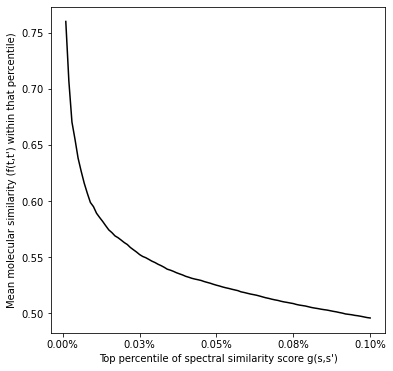

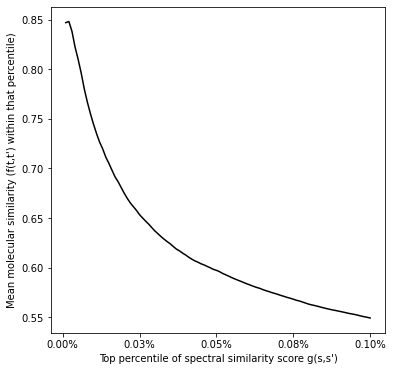

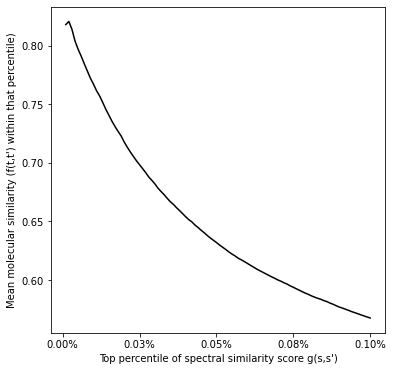

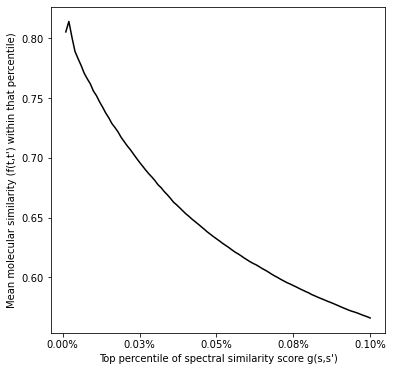

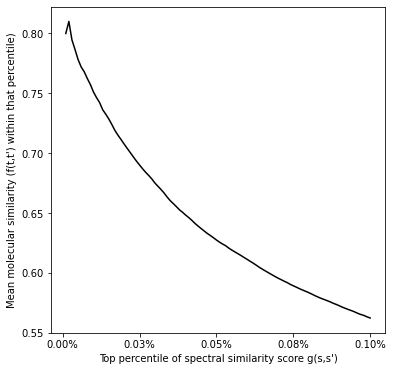

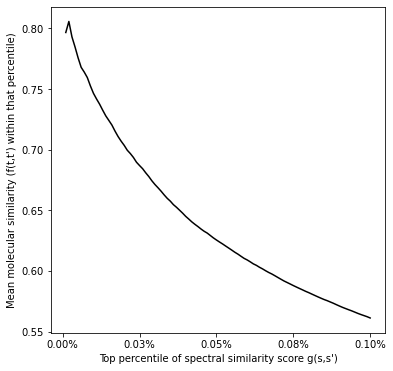

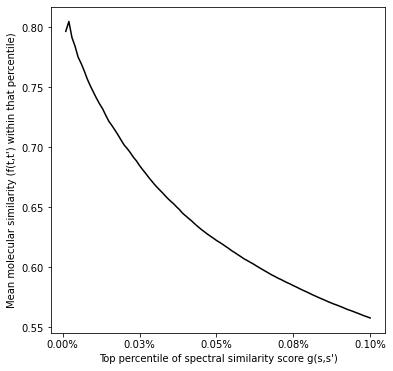

In [10]:
path_models = os.path.join(path_data, "trained_models")

for iteration in [1, 5, 10, 15, 20, 25, 30]:
    filename = "spec2vec_AllPositive_ratio05_filtered_iter_{}.model".format(iteration)
    model_file = os.path.join(path_models, filename)

    # Load pretrained model
    model = gensim.models.Word2Vec.load(model_file)
    
    # Score calculations
    spec2vec_similarity = Spec2VecParallel(model, intensity_weighting_power=0.5)
    similarity_matrix = spec2vec_similarity(documents, documents)
    
    # Compare to reference scores
    percentile_spec2vec_2dec_AllPos = plot_precentile(matrix_similarities_fingerprint_daylight,
                                                      similarity_matrix,
                                                      num_bins=100, show_top_percentile=0.1,
                                                      ignore_diagonal=True)

    filename = os.path.join(path_data, "percentile_spec2vec_2dec_AllPosModel_iter_{}.npy".format(iteration))
    np.save(filename, percentile_spec2vec_2dec_AllPos)
    
    filename = os.path.join(path_data, "similarities_spec2vec_2dec_AllPosModel_iter_{}.npy".format(iteration))
    np.save(filename, similarity_matrix)

In [13]:
spec2vec_similarity = Spec2VecParallel(model, intensity_weighting_power=0.5)

similarity_matrix = spec2vec_similarity(documents, documents)

## Compare results

In [50]:
path_models = os.path.join(path_data, "trained_models")

percentiles = []
for iteration in [1, 5, 10, 15, 20, 25, 30]:
    
    filename = os.path.join(path_data, "percentile_spec2vec_2dec_UniqueInchikeys_iter_{}.npy".format(iteration))
    percentiles.append(np.load(filename))
    

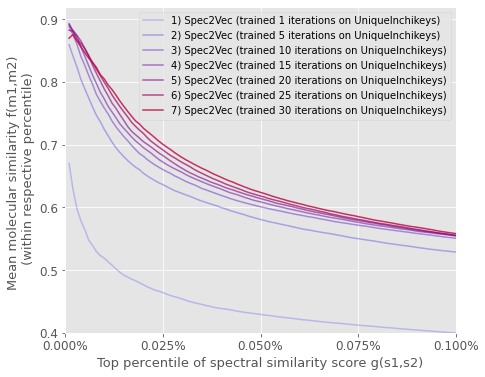

In [51]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]
iterations = [1, 5, 10, 15, 20, 25, 30]

for i, percentile in enumerate(percentiles):
    plt.plot(x_percentiles, percentiles[i], 
             color=(i/8, 0, 1-i/8, 0.2+i/10),
             label='{}) Spec2Vec (trained {} iterations on UniqueInchikeys)'.format((i+1), iterations[i]))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xticks(np.arange(0, 0.11, step=0.02), ('0.00%', '0.02%', '0.04%', '0.06%', '0.08%', '0.10%'))
plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.4, 0.92)
plt.savefig(os.path.join(path_data, 'Benchmarking_UniqueInchikeys_model_iterations.pdf'))

In [47]:
path_models = os.path.join(path_data, "trained_models")

percentiles = []
for iteration in [1, 5, 10, 15, 20, 25, 30]:
    
    filename = os.path.join(path_data, "percentile_spec2vec_2dec_AllPosModel_iter_{}.npy".format(iteration))
    percentiles.append(np.load(filename))
    

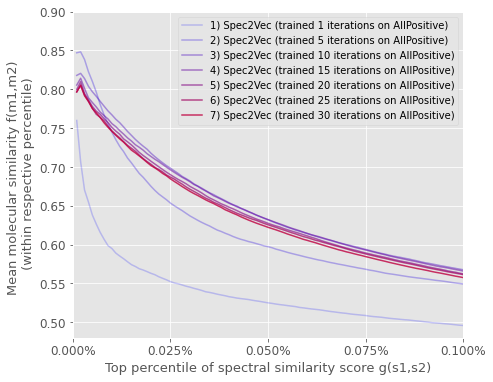

In [49]:
from matplotlib import pyplot as plt

#Compare all:
num_bins = 100
show_top_percentile = 0.1

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(7,6))

x_percentiles = (show_top_percentile / num_bins * (1 + np.arange(num_bins)))[::-1]
iterations = [1, 5, 10, 15, 20, 25, 30]

for i, percentile in enumerate(percentiles):
    plt.plot(x_percentiles, percentiles[i], 
             color=(i/8, 0, 1-i/8, 0.2+i/10),
             label='{}) Spec2Vec (trained {} iterations on AllPositive)'.format((i+1), iterations[i]))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xticks(np.arange(0, 0.11, step=0.02), ('0.00%', '0.02%', '0.04%', '0.06%', '0.08%', '0.10%'))
plt.xticks(np.linspace(0, show_top_percentile, 5),
           ["{:.3f}%".format(x) for x in np.linspace(0, show_top_percentile, 5)])
plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s1,s2)", fontsize=13)
plt.ylabel("Mean molecular similarity f(m1,m2) \n (within respective percentile)", fontsize=13)
plt.xlim(0, 0.1)
plt.ylim(0.48, 0.9)
plt.savefig(os.path.join(path_data, 'Benchmarking_AllPositive_model_iterations.pdf'))

---